In [2]:
"""
blocks.ipynb

Goal with this notebook is to analyze the impact of transitioning
from variable to fixed block times after the merge.

Towards the end of the notebook, there's a heavy focus on the impact of
this transition on the gas market.

TODO: Get data on block building process and whether portions of now fixed block time interval are more valuable.
"""

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import typing as tp

from ape import accounts, chain, Contract, networks
from scipy import stats

In [3]:
# SEE: https://gist.github.com/banteg/dcf6082ff7fc6ad51ce220146f29d9ff
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [4]:
# look at the current block
current_block = chain.blocks[-1]
current_block

Block(num_transactions=169, hash=HexBytes('0xf528504da5d3de70fe10de8b858378b119df15f57d4b6d6be70cc2a73aaee7b2'), number=15832588, parent_hash=HexBytes('0x03d837d7c0cb3b25b0aa3b3cee705874e3bccfad693d719e49a2617f551f5886'), size=104140, timestamp=1666791395, gas_limit=30000000, gas_used=19215044, base_fee=26696949800, difficulty=0, total_difficulty=58750003716598352816469)

In [5]:
# some relevant numbers
start_block_number = 15338009 # ~ 1 month before merge
merge_block_number = 15537394
current_block_number = current_block.number

In [6]:
# load EL blocks from csv if already queried, else do the query and save in csv
def load_blocks(fp: str) -> pd.DataFrame:
    if os.path.exists(fp):
        return pd.read_csv(fp)
    else:
        qb = chain.blocks.query('*', start_block=start_block_number)
        qb.to_csv(fp, index=False)
        return qb

In [7]:
# get blocks over last 2 months (since mid Aug to mid October)
# NOTE: query takes around ~15h if not from csv
%time qb = load_blocks('./data/blocks.csv')

CPU times: user 873 ms, sys: 73.6 ms, total: 946 ms
Wall time: 962 ms


In [8]:
qb

,num_transactions,hash,number,parent_hash,size,timestamp,gas_limit,gas_used,base_fee,difficulty,total_difficulty
0,97,"b'\xf0\x82\x95\x1e@\xe4by\xfc,\x15\xd6\xb6xFw\...",15338009,b'm\xb0\x02|\xa9}\x84\xa3\xdd\xc1\x84\xb6\xe4\...,39308,1660456780,30000000,9954560,8122412901,12045723921070914,56321843715293942409414
1,305,b'\xdb\x91:\xfc8Qk\xc1c\x82\xe2\xdbA\xe9b#R\xe...,15338010,"b'\xf0\x82\x95\x1e@\xe4by\xfc,\x15\xd6\xb6xFw\...",99210,1660456787,30000000,22464133,7780903344,12051743061157721,56321855767037003567135
2,51,b'\xb0\x0c2\x7f$\xc0\xec$i\xbf\xd9\xcb\x13\x0c...,15338011,b'\xdb\x91:\xfc8Qk\xc1c\x82\xe2\xdbA\xe9b#R\xe...,13806,1660456811,30000000,3781159,8264884155,12045995859944613,56321867813032863511748
3,24,"b""0\xbc\xf0\xa6\x89\xf1w\x1d\x9d\x05\x1c\xc8\x...",15338012,b'\xb0\x0c2\x7f$\xc0\xec$i\xbf\xd9\xcb\x13\x0c...,7824,1660456814,29970705,1551283,7492197312,12057896966730061,56321879870929830241809
4,63,b'`/\xd0\xe0\x7fvc>\x94\xf2\xd1\xca\xbf\x11\x9...,15338013,"b""0\xbc\xf0\xa6\x89\xf1w\x1d\x9d\x05\x1c\xc8\x...",16003,1660456819,29941438,3174533,6652621642,12063922050686819,56321891934851880928628
...,...,...,...,...,...,...,...,...,...,...,...
416045,189,b'\xecP\xf7g\x08\xc2\x19\x12_\x0c\xd8X\x92\x9b...,15754054,b'\x12Y[\x91y.\xb8\xcf\xd7\xca\xb5\x81\x87\x82...,82178,1665843383,30000000,18028304,14001417244,0,58750003716598352816469
416046,253,b'n\xf2R{ \xa9t\xabUD\xbc\x8e\x04B\x87\xb3\t\x...,15754055,b'\xecP\xf7g\x08\xc2\x19\x12_\x0c\xd8X\x92\x9b...,159816,1665843395,30000000,29936690,14354755142,0,58750003716598352816469
416047,137,b'\xb7\x06\xba9s\x7f>p\xd1\xa3\x16\xb0)Y\n\xd4...,15754056,b'n\xf2R{ \xa9t\xabUD\xbc\x8e\x04B\x87\xb3\t\x...,71368,1665843407,30000000,14425421,16141526205,0,58750003716598352816469
416048,117,b'\x86\xd9n\xfb+\x9e\n\xbc\xb3\x99\x155@\xbb\x...,15754057,b'\xb7\x06\xba9s\x7f>p\xd1\xa3\x16\xb0)Y\n\xd4...,56671,1665843419,30000000,11198548,16064238022,0,58750003716598352816469


In [9]:
# difference the timestamps and get the timestamp in date format
qb['dtimestamp'] = qb['timestamp'].diff()  # block time for this current block to be added
qb['date'] = pd.to_datetime(qb['timestamp'], unit='s')

In [10]:
qb

,num_transactions,hash,number,parent_hash,size,timestamp,gas_limit,gas_used,base_fee,difficulty,total_difficulty,dtimestamp,date
0,97,"b'\xf0\x82\x95\x1e@\xe4by\xfc,\x15\xd6\xb6xFw\...",15338009,b'm\xb0\x02|\xa9}\x84\xa3\xdd\xc1\x84\xb6\xe4\...,39308,1660456780,30000000,9954560,8122412901,12045723921070914,56321843715293942409414,NaN,2022-08-14 05:59:40
1,305,b'\xdb\x91:\xfc8Qk\xc1c\x82\xe2\xdbA\xe9b#R\xe...,15338010,"b'\xf0\x82\x95\x1e@\xe4by\xfc,\x15\xd6\xb6xFw\...",99210,1660456787,30000000,22464133,7780903344,12051743061157721,56321855767037003567135,7.0,2022-08-14 05:59:47
2,51,b'\xb0\x0c2\x7f$\xc0\xec$i\xbf\xd9\xcb\x13\x0c...,15338011,b'\xdb\x91:\xfc8Qk\xc1c\x82\xe2\xdbA\xe9b#R\xe...,13806,1660456811,30000000,3781159,8264884155,12045995859944613,56321867813032863511748,24.0,2022-08-14 06:00:11
3,24,"b""0\xbc\xf0\xa6\x89\xf1w\x1d\x9d\x05\x1c\xc8\x...",15338012,b'\xb0\x0c2\x7f$\xc0\xec$i\xbf\xd9\xcb\x13\x0c...,7824,1660456814,29970705,1551283,7492197312,12057896966730061,56321879870929830241809,3.0,2022-08-14 06:00:14
4,63,b'`/\xd0\xe0\x7fvc>\x94\xf2\xd1\xca\xbf\x11\x9...,15338013,"b""0\xbc\xf0\xa6\x89\xf1w\x1d\x9d\x05\x1c\xc8\x...",16003,1660456819,29941438,3174533,6652621642,12063922050686819,56321891934851880928628,5.0,2022-08-14 06:00:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
416045,189,b'\xecP\xf7g\x08\xc2\x19\x12_\x0c\xd8X\x92\x9b...,15754054,b'\x12Y[\x91y.\xb8\xcf\xd7\xca\xb5\x81\x87\x82...,82178,1665843383,30000000,18028304,14001417244,0,58750003716598352816469,12.0,2022-10-15 14:16:23
416046,253,b'n\xf2R{ \xa9t\xabUD\xbc\x8e\x04B\x87\xb3\t\x...,15754055,b'\xecP\xf7g\x08\xc2\x19\x12_\x0c\xd8X\x92\x9b...,159816,1665843395,30000000,29936690,14354755142,0,58750003716598352816469,12.0,2022-10-15 14:16:35
416047,137,b'\xb7\x06\xba9s\x7f>p\xd1\xa3\x16\xb0)Y\n\xd4...,15754056,b'n\xf2R{ \xa9t\xabUD\xbc\x8e\x04B\x87\xb3\t\x...,71368,1665843407,30000000,14425421,16141526205,0,58750003716598352816469,12.0,2022-10-15 14:16:47
416048,117,b'\x86\xd9n\xfb+\x9e\n\xbc\xb3\x99\x155@\xbb\x...,15754057,b'\xb7\x06\xba9s\x7f>p\xd1\xa3\x16\xb0)Y\n\xd4...,56671,1665843419,30000000,11198548,16064238022,0,58750003716598352816469,12.0,2022-10-15 14:16:59


<AxesSubplot: xlabel='number', ylabel='dtimestamp'>

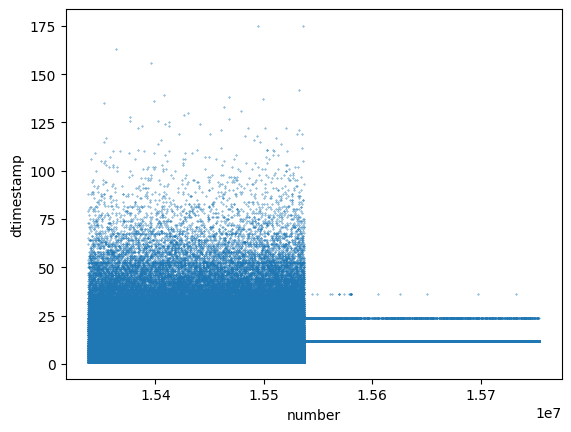

In [11]:
# plot block times over time
qb.plot(x='number', y='dtimestamp', kind='scatter', s=0.1)

<AxesSubplot: ylabel='Frequency'>

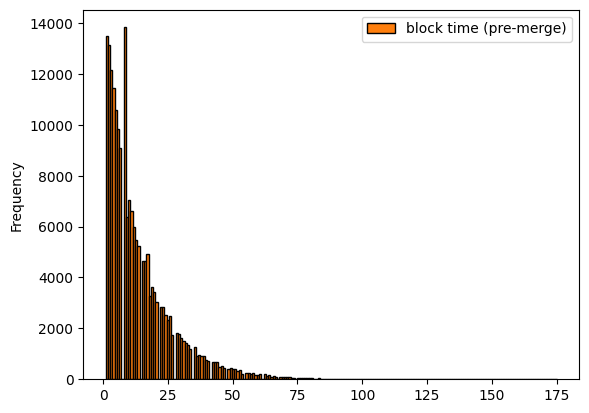

In [12]:
# plot distribution of block times before merge
qb[qb['number'] < merge_block_number].plot(y='dtimestamp', kind='hist', bins=200, color='C1', edgecolor='k', label='block time (pre-merge)')

<AxesSubplot: ylabel='Frequency'>

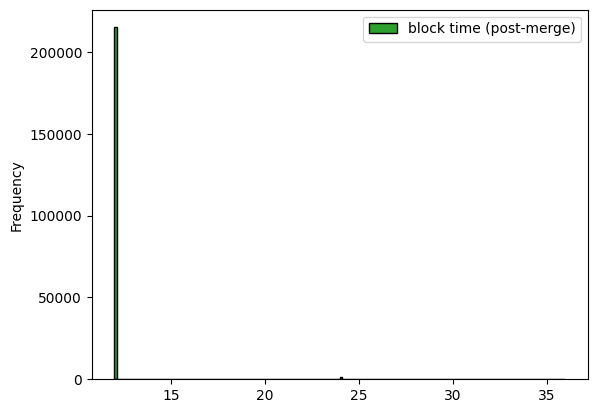

In [13]:
# plot distribution of block times after merge
# NOTE: some blocks come in at 24s
qb[qb['number'] >= merge_block_number].plot(y='dtimestamp', kind='hist', bins=200, color='C2', edgecolor='k', label='block time (post-merge)')

<AxesSubplot: xlabel='number', ylabel='dtimestamp'>

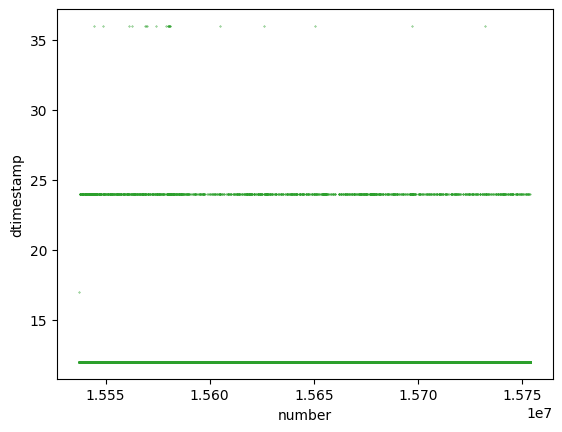

In [14]:
# scatter plot after merge
# NOTE: do have some blocks coming in at 2x, 3x fixed block length
# TODO: zoom in on 2x, 3x and answer why
qb[qb['number'] >= merge_block_number].plot(x='number', y='dtimestamp', kind='scatter', s=0.1, color='C2')

In [15]:
# how many come in at 24s? at 36s? (missed slots/blocks?)
#  ... ~ 0.7% of post merge blocks at 24s
#  ... ~ 0.0097% of post merge blocks at 36s
print('# blocks after merge:', qb[(qb['number'] >= merge_block_number)]['dtimestamp'].count())
print('# blocks after merge w block time == 24s:', qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] == 24)]['dtimestamp'].count())
print('# blocks after merge w block time == 36s:', qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] == 36)]['dtimestamp'].count())
print('fraction of blocks after merge w block time == 24s:', qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] == 24)]['dtimestamp'].count() / qb[(qb['number'] >= merge_block_number)]['dtimestamp'].count())
print('fraction of blocks after merge w block time == 36s:', qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] == 36)]['dtimestamp'].count() / qb[(qb['number'] >= merge_block_number)]['dtimestamp'].count())

# blocks after merge: 216665
# blocks after merge w block time == 24s: 1565
# blocks after merge w block time == 36s: 21
fraction of blocks after merge w block time == 24s: 0.007223132485634505
fraction of blocks after merge w block time == 36s: 9.692382249094224e-05


In [16]:
# look at the really weird block (not multiple of fixed block time == 12s)
#  ... first block of 17s block time happened at merge
qb[(qb['number'] >= merge_block_number) & (qb['dtimestamp'] % 12 != 0)]

,num_transactions,hash,number,parent_hash,size,timestamp,gas_limit,gas_used,base_fee,difficulty,total_difficulty,dtimestamp,date
199385,80,b'V\xa9\xbb\x03\x02\xdaD\xb8\xc0\xb3\xdfT\x07\...,15537394,b'U\xb1\x1b\x91\x83U\xb1\xef\x9c]\xb8\x100.\xb...,18559,1663224179,30000000,29983006,48811794595,0,58750003716598352816469,17.0,2022-09-15 06:42:59


In [17]:
# TODO: what's causing these missed slots/blocks? Use ape-beacon?

In [18]:
# TODO: Impact of shorter and consistent block times
# TODO:  a. [x] Going from ~13s to 12s should theoretically provide an ~8% increase in blocks per day
# TODO:  b. [x] Affect on fee-markets, on chain activity, etc

<AxesSubplot: xlabel='date'>

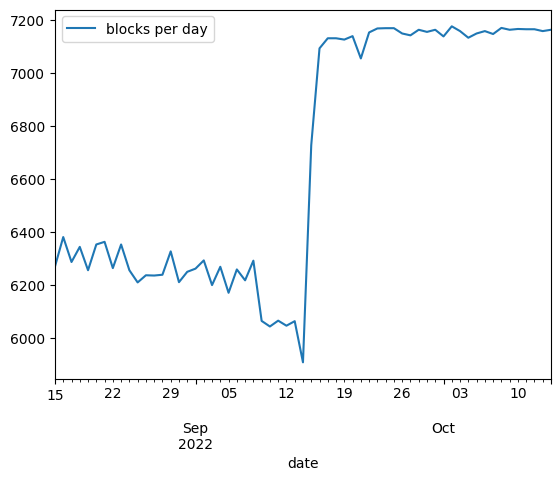

In [19]:
# look at rate of block production per day
#  ... seems pretty steady increase terms of # blocks produced per day
#  ... Seeing ~14% increase in blocks per day, which is significantly larger than expected ~8% increase.
#  ... Due to block times pre-merge in August being around 13.78s vs 13s in merge challenge wishlist
# NOTE: remove ends since query starts/ends between days
qb_block_count = qb.set_index('date').resample('1D').aggregate({'number': 'count'})[1:-1]
qb_block_count.plot(y='number', label='blocks per day')

In [20]:
# percent difference in block production rate (per day) between Aug 15 and Oct 15 2022
print('blocks per day (pre-merge; Aug 15 2022):', qb_block_count['number'][0])
print('blocks per day (post-merge; Oct 15 2022):', qb_block_count['number'][len(qb_block_count['number']) - 1])
print('frac diff in blocks per day:', qb_block_count['number'][len(qb_block_count['number']) - 1] / qb_block_count['number'][0] - 1)

blocks per day (pre-merge; Aug 15 2022): 6270
blocks per day (post-merge; Oct 15 2022): 7162
frac diff in blocks per day: 0.14226475279106854


In [21]:
# ~14% increase vs expected ~8%
#  ... ah it's because block times were around 13.78 sec one month pre-merge
print('avg block time (pre-merge; Aug 15 2022):', 86400 / qb_block_count['number'][0])
print('num blocks per day for 13s block time:', 86400 / 13.0)
print('hypothetical frac diff w/ 13s block time:', (86400 / 12.0) /(86400 / 13.0)-1)

avg block time (pre-merge; Aug 15 2022): 13.779904306220097
num blocks per day for 13s block time: 6646.153846153846
hypothetical frac diff w/ 13s block time: 0.08333333333333348


In [22]:
# store merge date for easier plotting
# can also find from difficulty == 0; SEE: https://eips.ethereum.org/EIPS/eip-3675#replacing-difficulty-with-0
merge_date = qb[qb['number'] == merge_block_number]['date'].iloc[0]
merge_date

Timestamp('2022-09-15 06:42:59')

<AxesSubplot: xlabel='date'>

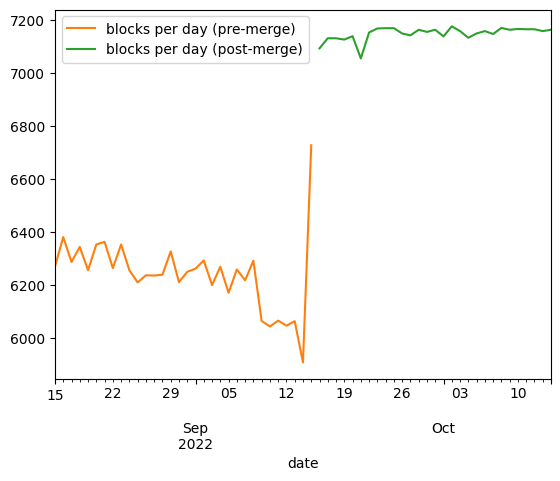

In [23]:
# plot again but with different colors pre v.s. post merge to show difference
ax = qb_block_count[qb_block_count.index < merge_date].plot(y='number', color='C1', label='blocks per day (pre-merge)')
qb_block_count[qb_block_count.index >= merge_date].plot(y='number', color='C2', ax=ax, label='blocks per day (post-merge)')

In [24]:
# look at base fee over time
# SEE: https://github.com/ethereum/EIPs/blob/master/EIPS/eip-1559.md#specification
# SEE: https://hackmd.io/@timbeiko/1559-resources
# SEE: https://github.com/ethereum/abm1559
qb_gwei = qb.copy()  # copy to make a column in gwei
qb_gwei['base_fee_gwei'] = qb_gwei['base_fee'] / 1e9

<AxesSubplot: xlabel='number', ylabel='base_fee_gwei'>

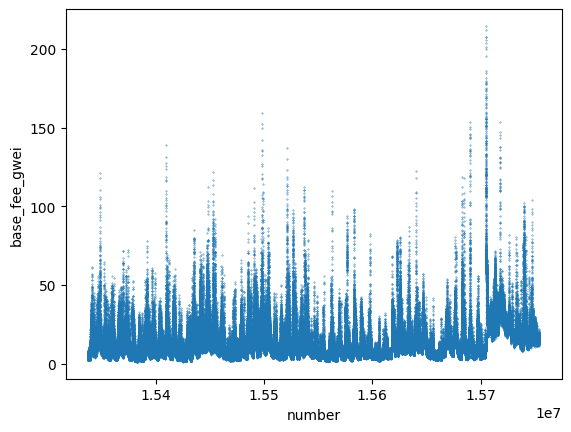

In [25]:
# plot history from August 15 to Oct 15
qb_gwei.plot(x='number', y='base_fee_gwei', kind='scatter', s=0.1)

<AxesSubplot: xlabel='number', ylabel='base_fee_gwei'>

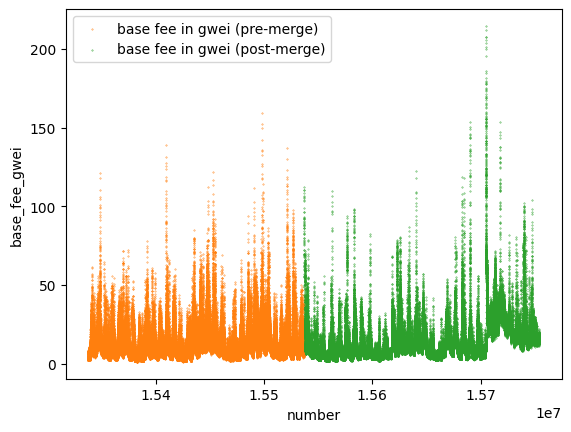

In [26]:
# split into pre and post merge colors
#  ... looks pretty similar pre v.s. post, but check distrs below
ax = qb_gwei[qb_gwei['number'] < merge_block_number].plot(x='number', y='base_fee_gwei', label='base fee in gwei (pre-merge)', color='C1', kind='scatter', s=0.1)
qb_gwei[qb_gwei['number'] >= merge_block_number].plot(x='number', y='base_fee_gwei', label='base fee in gwei (post-merge)', color='C2', kind='scatter', s=0.1, ax=ax)

<AxesSubplot: ylabel='Frequency'>

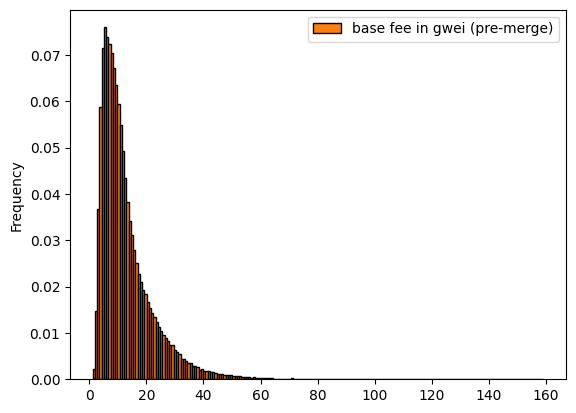

In [27]:
# plot histogram of base gas fee
#  ... pre merge
#  ... looks Levy like
qb_gwei[qb_gwei['number'] < merge_block_number].plot(y='base_fee_gwei', kind='hist', bins=200, color='C1', edgecolor='k', density=True, label='base fee in gwei (pre-merge)')

<AxesSubplot: ylabel='Frequency'>

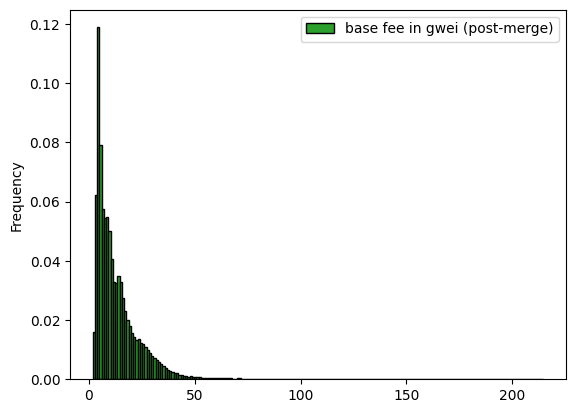

In [28]:
# plot histogram of base gas fee
#  ... post merge
#  ... looks pretty similar to above; slightly more concentrated at lower base fees
qb_gwei[qb_gwei['number'] >= merge_block_number].plot(y='base_fee_gwei', kind='hist', bins=200, color='C2', edgecolor='k', density=True, label='base fee in gwei (post-merge)')

<AxesSubplot: ylabel='Frequency'>

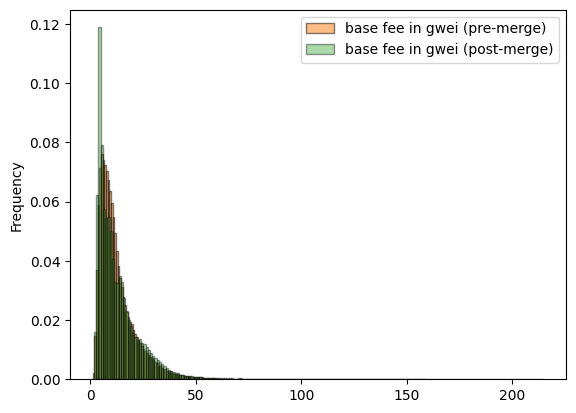

In [29]:
# plot histogram of base fee
#  ... pre vs post merge (one on top of other)
#  ... close to same distr, but potentially with heavier concentration in low fee range (maybe)
ax = qb_gwei[qb_gwei['number'] < merge_block_number].plot(y='base_fee_gwei', kind='hist', bins=200, color='C1', edgecolor='k', alpha=0.5, density=True, label='base fee in gwei (pre-merge)')
qb_gwei[qb_gwei['number'] >= merge_block_number].plot(y='base_fee_gwei', kind='hist', bins=200, color='C2', edgecolor='k', alpha=0.4, density=True, label='base fee in gwei (post-merge)', ax=ax)

In [30]:
%%capture
# Fit base gas fee to levy and check params near same
#  ... pre merge
params = stats.levy.fit(qb_gwei[(qb_gwei['number'] < merge_block_number)]['base_fee_gwei'])

params (levy): (1.1151434102545732, 6.605571293666644)


<AxesSubplot: ylabel='Frequency'>

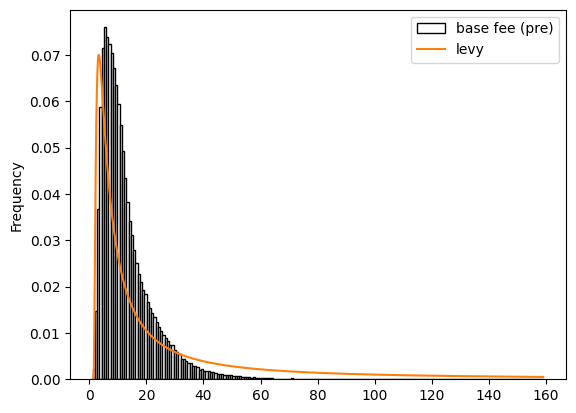

In [31]:
x = np.arange(qb_gwei[(qb_gwei['number'] < merge_block_number)]['base_fee_gwei'].min(), qb_gwei[(qb_gwei['number'] < merge_block_number)]['base_fee_gwei'].max(), 0.1)

ax = qb_gwei[(qb_gwei['number'] < merge_block_number)].plot(y='base_fee_gwei', kind='hist', bins=200, color='w', edgecolor='black', density=True, label='base fee (pre)')
print(f'params (levy):', params)

arg = params[:-2]
pdf = stats.levy.pdf(x, *arg, loc=params[-2], scale=params[-1])
df_pdf = pd.DataFrame(data={'levy': pdf}, index=x)
df_pdf.plot(ax=ax, color='C1')

In [32]:
%%capture
# Fit base gas fee to levy and check params near same
#  ... post merge
#  ... slightly different pre vs post merge in fit params. why? ... could just be events outside merge? (hard to tell)
params = stats.levy.fit(qb_gwei[(qb_gwei['number'] >= merge_block_number)]['base_fee_gwei'])

params (levy): (1.6886106552970064, 4.8476338045433565)


<AxesSubplot: ylabel='Frequency'>

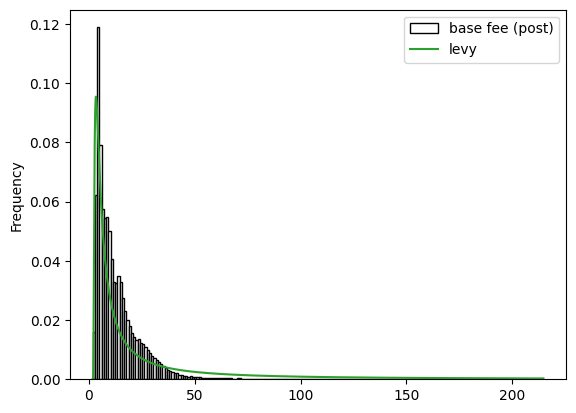

In [33]:
x = np.arange(qb_gwei[(qb_gwei['number'] >= merge_block_number)]['base_fee_gwei'].min(), qb_gwei[(qb_gwei['number'] >= merge_block_number)]['base_fee_gwei'].max(), 0.1)

ax = qb_gwei[(qb_gwei['number'] >= merge_block_number)].plot(y='base_fee_gwei', kind='hist', bins=200, color='w', edgecolor='black', density=True, label='base fee (post)')
print(f'params (levy):', params)

arg = params[:-2]
pdf = stats.levy.pdf(x, *arg, loc=params[-2], scale=params[-1])
df_pdf = pd.DataFrame(data={'levy': pdf}, index=x)
df_pdf.plot(ax=ax, color='C2')

In [34]:
# base fee gas at block level looks slightly more concentrated near zero post merge
# fitting assuming levy, have:
#  ... shift around 1 (pre) vs 1.6 (post)
#  ...  => probs within est error (TODO)
#  ... scale around 6.6 (pre) vs 4.8 (post)
#  ...  => suggests higher concentration near lower base fee range post-merge
#  ...  => but likely too little data to tell if this is switch to POS or simply market conditions
#
# TODO: verify goodness of fits and est errors

In [35]:
# TODO: Pre/post-merge execution layer health and metrics:
# TODO:  a. [x] Changes in gas limit?
# TODO:  b. [x] Empty vs full blocks pre vs post merge?
# TODO:  c. [ ] Utilization of PREVRANDAO

<AxesSubplot: xlabel='number', ylabel='gas_limit'>

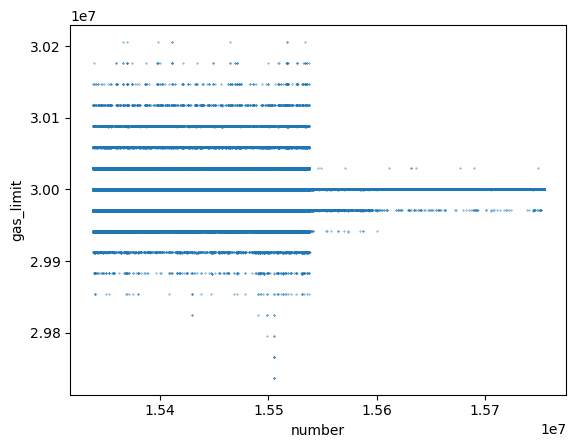

In [36]:
# check out some gas related quantites pre/post merge
# look at the gas limit post merge ...
#  ... looks like less variance in gas limit post merge
qb.plot(x='number', y='gas_limit', kind='scatter', s=0.1)

<AxesSubplot: xlabel='number', ylabel='gas_limit'>

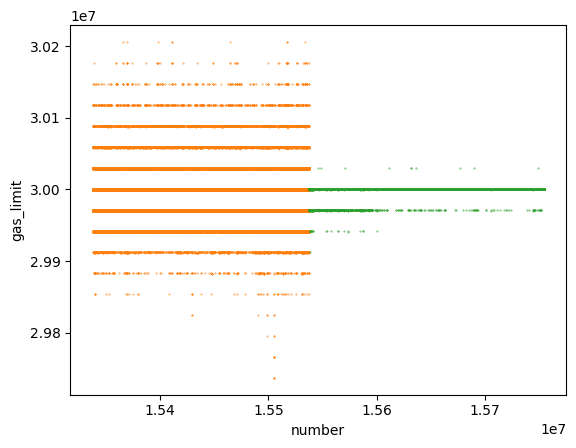

In [37]:
# plot gas limit with different colors for pre v.s. post merge to emphasize difference
ax = qb[qb['number'] < merge_block_number].plot(x='number', y='gas_limit', kind='scatter', color='C1', s=0.1)
qb[qb['number'] >= merge_block_number].plot(x='number', y='gas_limit', kind='scatter', color='C2', s=0.1, ax=ax)

<AxesSubplot: ylabel='Frequency'>

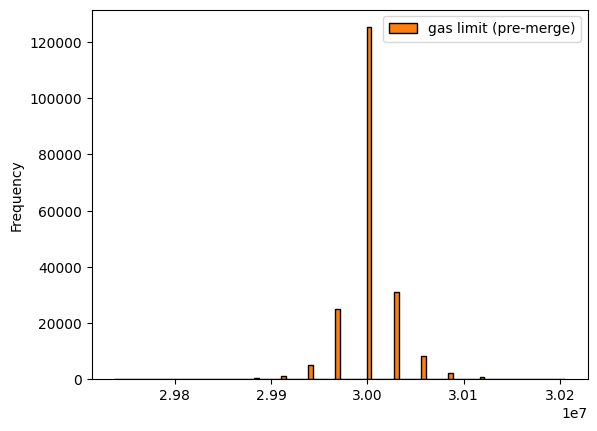

In [73]:
# to be sure plot histograms pre and post merge
qb[qb['number'] < merge_block_number].plot(y='gas_limit', kind='hist', bins=100, label='gas limit (pre-merge)', color='C1', edgecolor='k')

<AxesSubplot: ylabel='Frequency'>

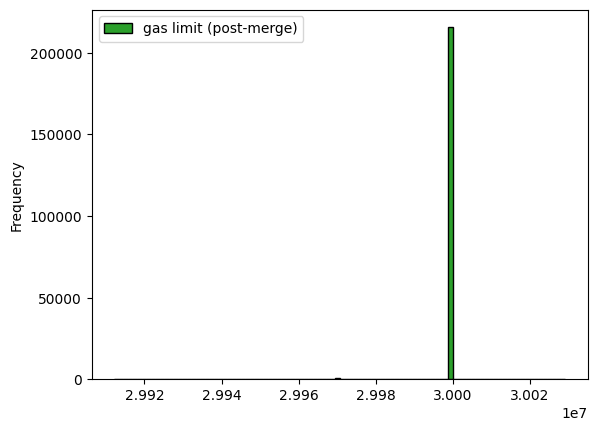

In [74]:
# gas limit post merge
#  ... really concentrated around 30,000,000 gas with few deviations
qb[qb['number'] >= merge_block_number].plot(y='gas_limit', kind='hist', bins=100, label='gas limit (post-merge)', color='C2', edgecolor='k')

In [40]:
# calculate some sample stats pre v.s. post merge to verify standard dev reduction
qb[qb['number'] < merge_block_number]['gas_limit'].describe()

count    1.993850e+05
mean     3.000275e+07
std      2.627404e+04
min      2.973731e+07
25%      2.999997e+07
50%      3.000000e+07
75%      3.000000e+07
max      3.020567e+07
Name: gas_limit, dtype: float64

In [41]:
qb[qb['number'] >= merge_block_number]['gas_limit'].describe()

count    2.166650e+05
mean     2.999989e+07
std      1.881200e+03
min      2.991220e+07
25%      3.000000e+07
50%      3.000000e+07
75%      3.000000e+07
max      3.002930e+07
Name: gas_limit, dtype: float64

In [42]:
# standard deviation reduced post-merge by factor of ~ 14 (down -93%) while mean about the same
qb[qb['number'] >= merge_block_number]['gas_limit'].describe()['std'] / qb[qb['number'] < merge_block_number]['gas_limit'].describe()['std']

0.07159919905180735

In [43]:
# Look at gas utilization for each block pre v.s. post-merge ...

In [44]:
# calc fraction of gas limit used per block
qb['gas_filled'] = qb['gas_used'] / qb['gas_limit']

gas filled >= 0.99 (frequency pre-merge): 0.1988865762218823
gas filled <= 0.01 (frequency pre-merge): 0.041663114075783034


<AxesSubplot: ylabel='Frequency'>

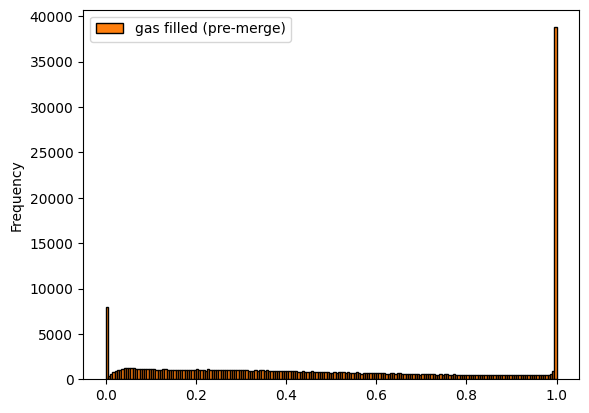

In [45]:
# plot distribution of gas limit utilization
#  ... pre merge
#  ... ~ 20% of time pre-merge, block is full
#  ... ~ 4% of time pre-merge, block is empty
print('gas filled >= 0.99 (frequency pre-merge):', qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] >= 0.99)]['gas_filled'].count() / qb[(qb['number'] < merge_block_number)]['gas_filled'].count())
print('gas filled <= 0.01 (frequency pre-merge):', qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] <= 0.01)]['gas_filled'].count() / qb[(qb['number'] < merge_block_number)]['gas_filled'].count())
qb[qb['number'] < merge_block_number].plot(y='gas_filled', kind='hist', bins=200, label='gas filled (pre-merge)', color='C1', edgecolor='k')

0.01 < gas filled < 0.99 (frequency pre-merge): 0.7594503097023346


<AxesSubplot: ylabel='Frequency'>

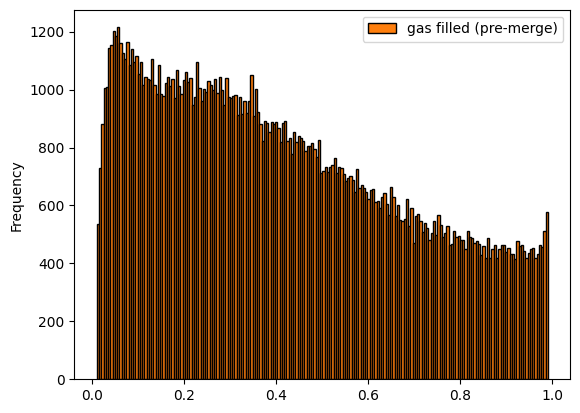

In [86]:
# plot distribution of gas limit utilization
#  ... pre merge but ignore completely full and empty blocks
#  ... somewhat close to uniform (with a bit of dropoff; maybe chi squared / Levy?) for gas utilization in between 0 and 1
#  ... ~ 76% of time pre-merge, block is partially filled
print('0.01 < gas filled < 0.99 (frequency pre-merge):', qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] > 0.01) & (qb['gas_filled'] < 0.99)]['gas_filled'].count() / qb[(qb['number'] < merge_block_number)]['gas_filled'].count())
qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)].plot(y='gas_filled', kind='hist', bins=200, label='gas filled (pre-merge)', color='C1', edgecolor='k')

gas filled >= 0.99 (frequency post-merge): 0.08736067200516927
gas filled <= 0.01 (frequency post-merge): 0.0065308194678420604


<AxesSubplot: ylabel='Frequency'>

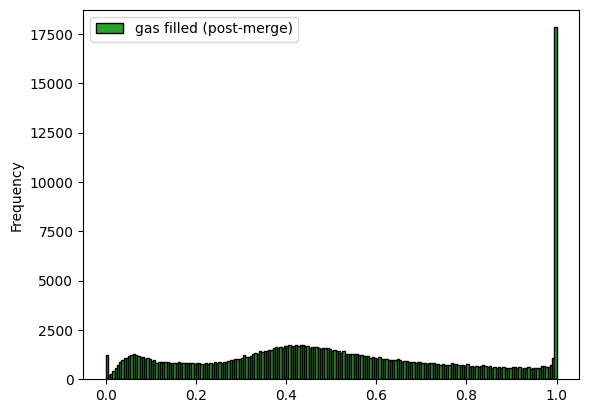

In [47]:
# plot distribution of gas limit utilization
#  ... post merge
#  ... woah, that's pretty cool and weird near 0.5 (?); Q: why does % of gas filled post merge peak around 0.5 (sorta bell curved; ignoring extreme of filled completely == 1)
#  ... also seeing significant reduction in frequency of extremes (0, 1) for gas utilization in block vs pre-merge
#  ... ~ 9% of time post-merge, block is full (~ 50% decrease)
#  ... ~ 1% of time post-merge, block is empty (~ 80% decrease)
#  ...   does seem like empty block mining has decreased **significantly**
print('gas filled >= 0.99 (frequency post-merge):', qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] >= 0.99)]['gas_filled'].count() / qb[(qb['number'] >= merge_block_number)]['gas_filled'].count())
print('gas filled <= 0.01 (frequency post-merge):', qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] <= 0.01)]['gas_filled'].count() / qb[(qb['number'] >= merge_block_number)]['gas_filled'].count())
qb[qb['number'] >= merge_block_number].plot(y='gas_filled', kind='hist', bins=200, label='gas filled (post-merge)', color='C2', edgecolor='k')

0.01 < gas filled < 0.99 (frequency post-merge): 0.9061085085269887


<AxesSubplot: ylabel='Frequency'>

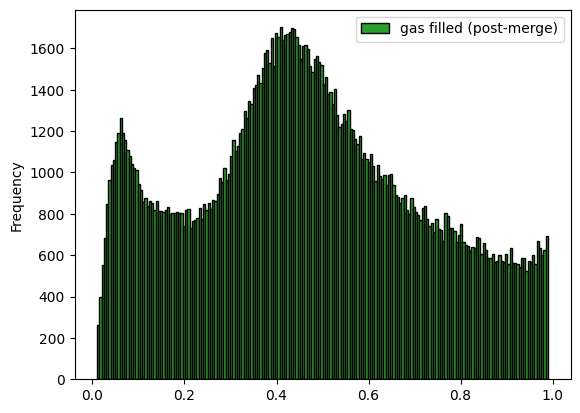

In [87]:
# plot distribution of gas limit utilization
#  ... post merge but ignore completely full and empty blocks
#  ... somewhat close to Gaussian (center at ~ 50%) for gas utilization in between 0 and 1
#  ... ~ 90% of time post-merge, block is partially filled (~ 18% increase)
print('0.01 < gas filled < 0.99 (frequency post-merge):', qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] > 0.01) & (qb['gas_filled'] < 0.99)]['gas_filled'].count() / qb[(qb['number'] >= merge_block_number)]['gas_filled'].count())
qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)].plot(y='gas_filled', kind='hist', bins=200, label='gas filled (post-merge)', color='C2', edgecolor='k')

In [49]:
# TODO:
#  ... Q: why does % of gas filled post merge seem to be sorta normally distributed around 0.5 (excluding ~1 utilization numbers)
#  ... Q: is this expected? interesting ...
#  ... Q: is this randomness from variable block times moving to randomness in gas utilization?
#  ... Q: why would this peak around 50% gas filled?

In [88]:
# initial sample stats on gas pre v.s. post merge
#  ... pre-merge
qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)].filter(['num_transactions', 'gas_limit', 'gas_used', 'base_fee', 'gas_filled']).describe()

,num_transactions,gas_limit,gas_used,base_fee,gas_filled
count,151423.000000,1.514230e+05,1.514230e+05,1.514230e+05,151423.000000
mean,139.629389,3.000202e+07,1.249006e+07,1.325955e+10,0.416293
std,96.986045,2.593564e+04,8.075913e+06,9.947713e+09,0.269158
min,1.000000,2.973731e+07,2.998560e+05,1.162411e+09,0.010004
25%,63.000000,2.999997e+07,5.623104e+06,6.665960e+09,0.187437
50%,122.000000,3.000000e+07,1.130021e+07,1.041859e+10,0.376640
75%,200.000000,3.000000e+07,1.860338e+07,1.661743e+10,0.620047
max,1161.000000,3.020567e+07,2.985907e+07,1.591882e+11,0.989989


In [89]:
# initial sample stats on gas pre v.s. post merge
# ... post-merge
qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)].filter(['num_transactions', 'gas_limit', 'gas_used', 'base_fee', 'gas_filled']).describe()

,num_transactions,gas_limit,gas_used,base_fee,gas_filled
count,196322.000000,1.963220e+05,1.963220e+05,1.963220e+05,196322.000000
mean,150.256701,2.999988e+07,1.399674e+07,1.316863e+10,0.466560
std,88.088624,1.917262e+03,7.501416e+06,1.140786e+10,0.250048
min,1.000000,2.991220e+07,3.005330e+05,1.869525e+09,0.010018
25%,91.000000,3.000000e+07,8.593282e+06,5.348233e+09,0.286456
50%,143.000000,3.000000e+07,1.362298e+07,9.639789e+09,0.454101
75%,200.000000,3.000000e+07,1.931976e+07,1.701300e+10,0.643992
max,1341.000000,3.002930e+07,2.969997e+07,2.147161e+11,0.989999


In [90]:
# Hard to tell much difference with gas filled from simple describe. Move to higher order moments (skew, kurtosis)
# ... pre-merge
print("skew (pre-merge):", qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)]['gas_filled'].skew())
print("excess kurtosis (pre-merge):", qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)]['gas_filled'].kurt())

skew (pre-merge): 0.40161652279361437
excess kurtosis (pre-merge): -0.9230875931166516


In [91]:
# Hard to tell much difference with gas filled from simple describe. Move to higher order moments (skew, kurtosis)
# ... post-merge
# ... NOTE: far less positively skewed, but not as much excess kurtosis => 0 as expected from plots
print("skew (post-merge):", qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)]['gas_filled'].skew())
print("excess kurtosis (post-merge):", qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)]['gas_filled'].kurt())

skew (post-merge): 0.15090104480195216
excess kurtosis (post-merge): -0.7792892578389612


<AxesSubplot: ylabel='Frequency'>

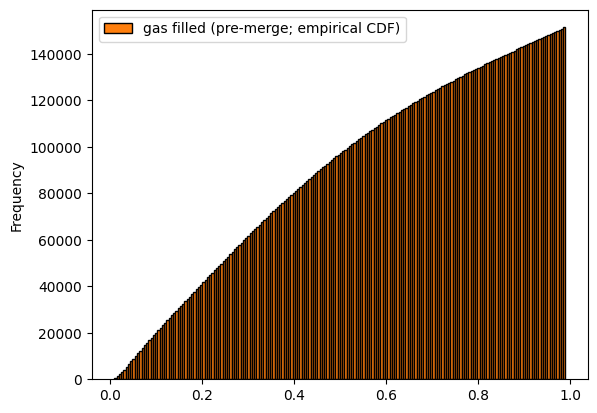

In [92]:
# Plot empirical cdfs ...
# ... pre-merge
qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)].plot(y='gas_filled', kind='hist', cumulative=True, bins=200, label='gas filled (pre-merge; empirical CDF)', color='C1', edgecolor='k')

<AxesSubplot: ylabel='Frequency'>

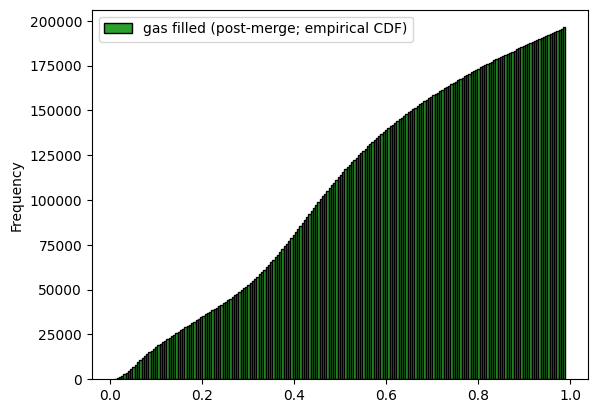

In [93]:
# Plot empirical cdfs ...
# ... post-merge
qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)].plot(y='gas_filled', kind='hist', cumulative=True, bins=200, label='gas filled (post-merge; empirical CDF)', color='C2', edgecolor='k')

In [56]:
# Slight adjust toward normality in CDF but seems too early to be sure

In [97]:
# fit histograms and plot
size = qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)]['gas_filled'].count()
x = np.arange(size) / size
dist_names = ['norm', 'cauchy', 'logistic', 'gamma', 't', 'weibull_max', 'levy', 'uniform']

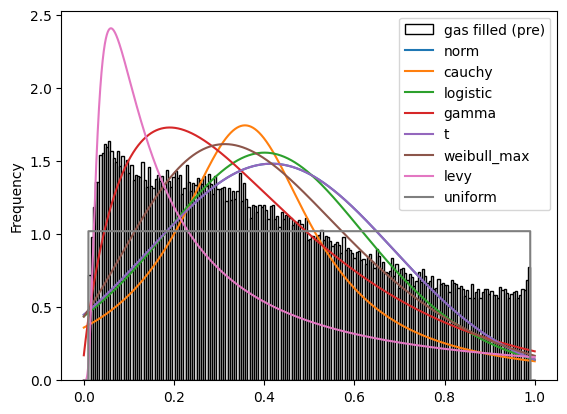

In [98]:
%%capture --no-display
# Plot multiple dist fits over gas filled histogram
# ... pre-merge
# SEE: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

# NOTE: hard to tell, need more data.
params_data = {}
ax = qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)].plot(y='gas_filled', kind='hist', bins=200, color='w', edgecolor='black', density=True, label='gas filled (pre)')
for dist_name in dist_names:
    params = getattr(stats, dist_name).fit(qb[(qb['number'] < merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)]['gas_filled'])
    arg = params[:-2]
    pdf = getattr(stats, dist_name).pdf(x, *arg, loc=params[-2], scale=params[-1])
    df_pdf = pd.DataFrame(data={dist_name: pdf}, index=x)
    df_pdf.plot(ax=ax)
    
    # store param fits for later use in cell below
    params_data[dist_name] = [*params] + [None for _ in range(4 - len(params))]

In [99]:
# Fit params to gas filled
# ... pre-merge
pd.DataFrame(data=params_data).T

,0,1,2,3
norm,4.162929e-01,0.269158,NaN,NaN
cauchy,3.573619e-01,0.182455,NaN,NaN
logistic,4.006822e-01,0.160482,NaN,NaN
gamma,1.866238e+00,-0.005114,0.225806,NaN
t,5.490127e+06,0.416289,0.269157,NaN
weibull_max,1.432434e+01,3.564684,3.268461,NaN
levy,-3.895709e-03,0.192010,NaN,NaN
uniform,1.000363e-02,0.979985,NaN,NaN


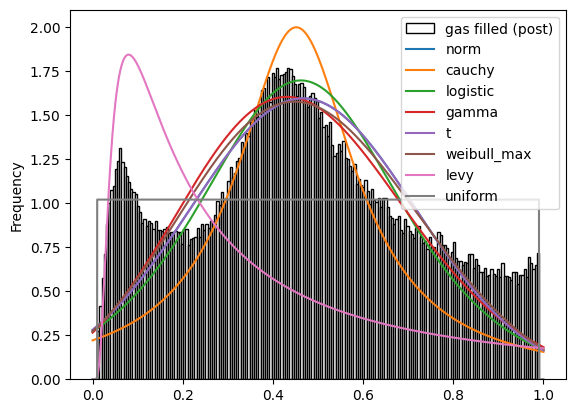

In [100]:
%%capture --no-display
# Plot multiple dist fits over gas filled histogram
# ... post-merge
# SEE: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

# NOTE: hard to tell, need more data.
# NOTE: still, currently looks approx symmetric around ~ 45-46% utilization, if this is anything interesting
params_data = {}
ax = qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)].plot(y='gas_filled', kind='hist', bins=200, color='w', edgecolor='black', density=True, label='gas filled (post)')
for dist_name in dist_names:
    params = getattr(stats, dist_name).fit(qb[(qb['number'] >= merge_block_number) & (qb['gas_filled'] < 0.99) & (qb['gas_filled'] > 0.01)]['gas_filled'])
    arg = params[:-2]
    pdf = getattr(stats, dist_name).pdf(x, *arg, loc=params[-2], scale=params[-1])
    df_pdf = pd.DataFrame(data={dist_name: pdf}, index=x)
    df_pdf.plot(ax=ax)
    
    # store param fits for later use in cell below
    params_data[dist_name] = [*params] + [None for _ in range(4 - len(params))]

In [101]:
# Fit params to gas filled
# ... post-merge
pd.DataFrame(data=params_data).T

,0,1,2,3
norm,4.665596e-01,0.250047,NaN,NaN
cauchy,4.516836e-01,0.159239,NaN,NaN
logistic,4.617580e-01,0.147302,NaN,NaN
gamma,5.279312e+01,-1.356407,0.03451,NaN
t,1.074673e+07,0.466563,0.25005,NaN
weibull_max,3.794732e+00,1.296299,0.92006,NaN
levy,-3.832688e-03,0.250901,NaN,NaN
uniform,1.001777e-02,0.979981,NaN,NaN


In [102]:
# TODO: goodness of fit stats

<AxesSubplot: xlabel='number', ylabel='gas_filled'>

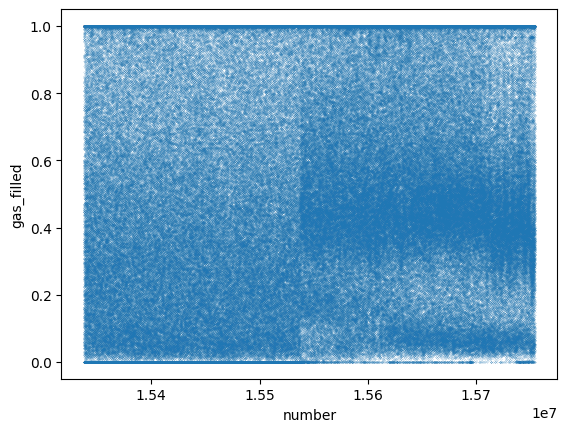

In [103]:
# Plot gas filled over time to get a sense historically (and around merge)
qb.plot(x='number', y='gas_filled', kind='scatter', s=0.01)

<AxesSubplot: xlabel='number', ylabel='gas_filled'>

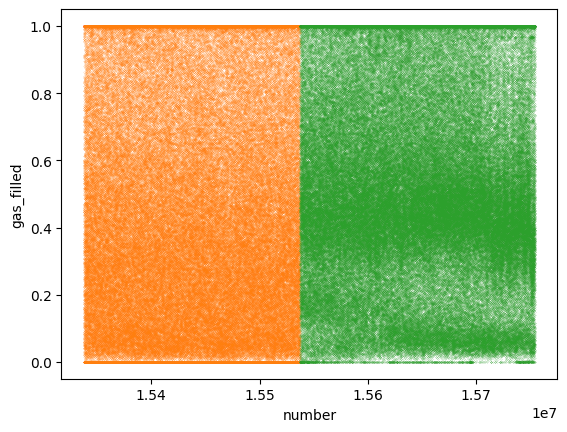

In [104]:
# Plot gas filled over time to get a sense historically (and around merge);
# Change colors pre/post merge to make it easier to compare.
#  ... does seem to also suggest some level of concentration around ~ 0.5 utilization post-merge
#       but is there a good reason to expect this?
#  ... unclear if will be significant once more data comes in
#
#  ... likely due to EIP1559 spec
#  ... SEE: https://github.com/ethereum/EIPs/blob/master/EIPS/eip-1559.md#specification
#  ...   ELASTICITY_MULTIPLIER = 2
#  ...   parent_gas_target = self.parent(block).gas_limit // ELASTICITY_MULTIPLIER
#  ... but why take effect post-merge? check out blocks over life of EIP1559 to see if pre-merge distr appears valid (only looked at 1 month above)
ax = qb[(qb['number'] < merge_block_number)].plot(x='number', y='gas_filled', kind='scatter', s=0.01, color='C1')
qb[(qb['number'] >= merge_block_number)].plot(x='number', y='gas_filled', kind='scatter', s=0.01, color='C2', ax=ax)

In [105]:
# Looks like ...
#  ... pre-merge: miners were filling empty blocks pretty frequently, but close to uniform distribution
#  ...            of gas used when ignoring utilization numbers of ~ 1
# 
#  ... post-merge: in POS, seeing gas used look more normally distributed (somewhat) around 50% utilization
#  ...             when ignoring utilization numbers of ~ 1
#  ...             NOTE: 50% utilization is the long-term average gas target from EIP1559 spec
#  ...             SEE: https://notes.ethereum.org/@vbuterin/eip-1559-faq
#  ...             Q: Why was distribution *not* around gas target pre-merge then? -- see gas.ipynb for more than 1 month of data analysis
#  ...             Q: Any relevance to idea might be a transformation from Poisson randomness in block times in POW to "Gaussian" randomness in gas utilization for POS?

In [106]:
# TODO: prevrandao utilization
# TODO: ... SEE: https://eips.ethereum.org/EIPS/eip-4399
# TODO: ... compare randao outputs to uniform distribution .. how good is it?
# TODO: ... Q: does this mean contracts using this OPCODE now?
# TODO: ... If so, need to sort through deployed contracts between Aug and Oct that have block.difficulty (solidity) in them?

In [107]:
# TODO: need mixhash for randao OR use beacon client (ape-beacon?)

In [108]:
# TODO: use ape-beacon to answer:
# TODO: ... [] Validator registrations leading up to and after the Merge?

In [109]:
# TODO: qb['num_transactions'].sum() to know how many lines in transactions csv
# TOD: Then chunk into parts (for analysis), focusing on ~ 1/4 of file around merge
qb['num_transactions'].sum()

69567381

In [110]:
# TODO: look at gas in txs: priority fee, max fee
# Q: is it cheaper for users to get tx included?
# Q: does merge reduce tx fees post merge due to lack of variability?